## Victoria Liu

Note: Much of the background is taken from my SURF proposal, which my mentors Professor Shreyas Vasanawala and Dr. Kanghyun Ryu have helped edit. Since I am new to both MRIs and deep learning, my BE/Bi205 proposal is more about testing different existing architectures and trying to replicate the success already reported in [NYU fastMRI's paper](https://arxiv.org/pdf/1811.08839.pdf). I will not be creating something that is completely my own, nor do I anticipate contributing something completely novel...but hopefully this class will give me the foundation to contribute something novel in the future! I will cite all relevant papers and code. For reference, my SURF project is focused on using multi-task learning in MRI reconstruction, while this project seeks to build a GAN/U-NET for MRI super-resolution.

### Problem statement
Magnetic resonance imaging (MRI) is a vital diagnostic tool in medicine. Unfortunately, MRIs have a long scan time, lasting from a few minutes to an hour. This poses an issue for patients who cannot stay still for the minimum required time and may be instead referred to quicker but more harmful imaging modalities such as CT. To reduce MRI scan time, accelerated MR reconstruction methods based on numerical optimization have been developed and used (Ye, 2019).


More recently, the burgeoning field of deep learning has fueled data-driven neural network models for MRI reconstruction. In 2020, in a collaboration termed “fastMRI'' between Facebook AI and NYU Langone Health, researchers reconstructed complete knee MR images from subsampled k-space data (Sriram et al., 2020). Notably, they were able to sample about 75% less k-space data and still generate images that, to board certified radiologists, were “diagnostically interchangeable” with fully sampled MR images (Recht, 2020). The study showed that it is possible to greatly accelerate scan time and use deep learning to reconstruct diagnostic quality MRIs.


### Proposal
In this project, we investigate methods to deblur or simulate super-resolution of MR images reconstructed from undersampled k-spaces. Unlike NYU fastMRI, we will work in the image space, rather than the k-space. This will allow us to apply mainstream computer vision algorithms. We anticipate building a GAN, where the generator receives an undersampled MR images and trains to produce a super resolution version of the MR image. Given the original underampled image and a "high resolution" image, the discriminator must determine whether the "high resolution" image is from the generator or the original ground truth of the fully sampled MR image. The generator architecture will likely be some form of convolutional U-net. We will use mean squared error for loss, and we use PSNR and SSIM to measure how well our generated MRIs match the ground truth.


### Dataset
The dataset comes from from the [NYU fastMRI Initiative database](fastmri.med.nyu.edu), with papers describing the dataset found [here](https://pubs.rsna.org/doi/10.1148/ryai.2020190007) and [here](https://arxiv.org/abs/1811.08839). The datset was applied for via the website. "As such, NYU fastMRI investigators provided data but did not participate in analysis or writing of this report. A listing of NYU fastMRI investigators, subject to updates, can be found at: [fastmri.med.nyu.edu](fastmri.med.nyu.edu). The primary goal of fastMRI is to test whether machine learning can aid in the reconstruction of medical images." - from the website.

The dataset consists of k-space and reconstructed image data of more than $1500$ fully sampled knee MRIs and $6970$ brain MRIs. Due to disk quota limitations on the cluster system, however, we are currently only using $101$ MRIs for the training, testing, and validation, due to issues with disc quotas on the Caltech clusters. For now, we will be working with the single coil data. Let's load the dataset in to discuss more. Note that `sigpy` interactive tools only work in Jupyter Notebooks, and not Jupyter Labs.

In [1]:
import os
import glob

# h5py can read hdf5 dataset
import h5py

# delete bad data files
from send2trash import send2trash

# fastmri has some k-space undersampling functions we can use
# git clone https://github.com/facebookresearch/fastMRI.git
# go to the fastmri directory
# pip install -e.
import fastmri

# We will use this functions to generate masks
from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFunc

# sigpy is apparently a good MRI viewing tool
# pip install sigpy
import sigpy as sp
import sigpy.plot as pl

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib

%matplotlib notebook

### Loading data

In [2]:
# define constants
DATASET = 'singlecoil_train'
AXES = {
        'singlecoil_train' : (1, 2),
        'multicoil_train' : (2, 3),
       }
PATH = os.path.join(os.path.dirname(os.getcwd()), DATASET)
mri_paths = glob.glob(os.path.join(PATH, '*.h5'))

We will first see what a single MRI data point looks like. We see that a single `.h5` file contains both `kspace` and `reconstruction_rss` (root sum squared) reconstructions of the image from the k-space. The reconstructed image will be the "ground truth" high resolution image in our model.

In [3]:
with h5py.File(
    '/central/home/vliu/bebi205/singlecoil_train/file1000142.h5',
    'r'
) as hr:
    print(hr.keys()) # see what is already in data
    kspace = hr['kspace'][:] # saving kspace to numpy
    img = hr['reconstruction_rss'][:]

    # printing size of the variable
    print('kspace:{},'.format(
        kspace.shape,
        img.shape
    ))

    # Kspace has 33 slices, 640 x 372 2d kspace data

<KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>
kspace:(33, 640, 372),


We can also plot the k-space in Jupyter Notebook (not Labs). The k-space is in frequency space, so we are not expecting anything illuminating, although we can look at it in log-scale.

### Plotting k-space and reconstructed image

<IPython.core.display.Javascript object>


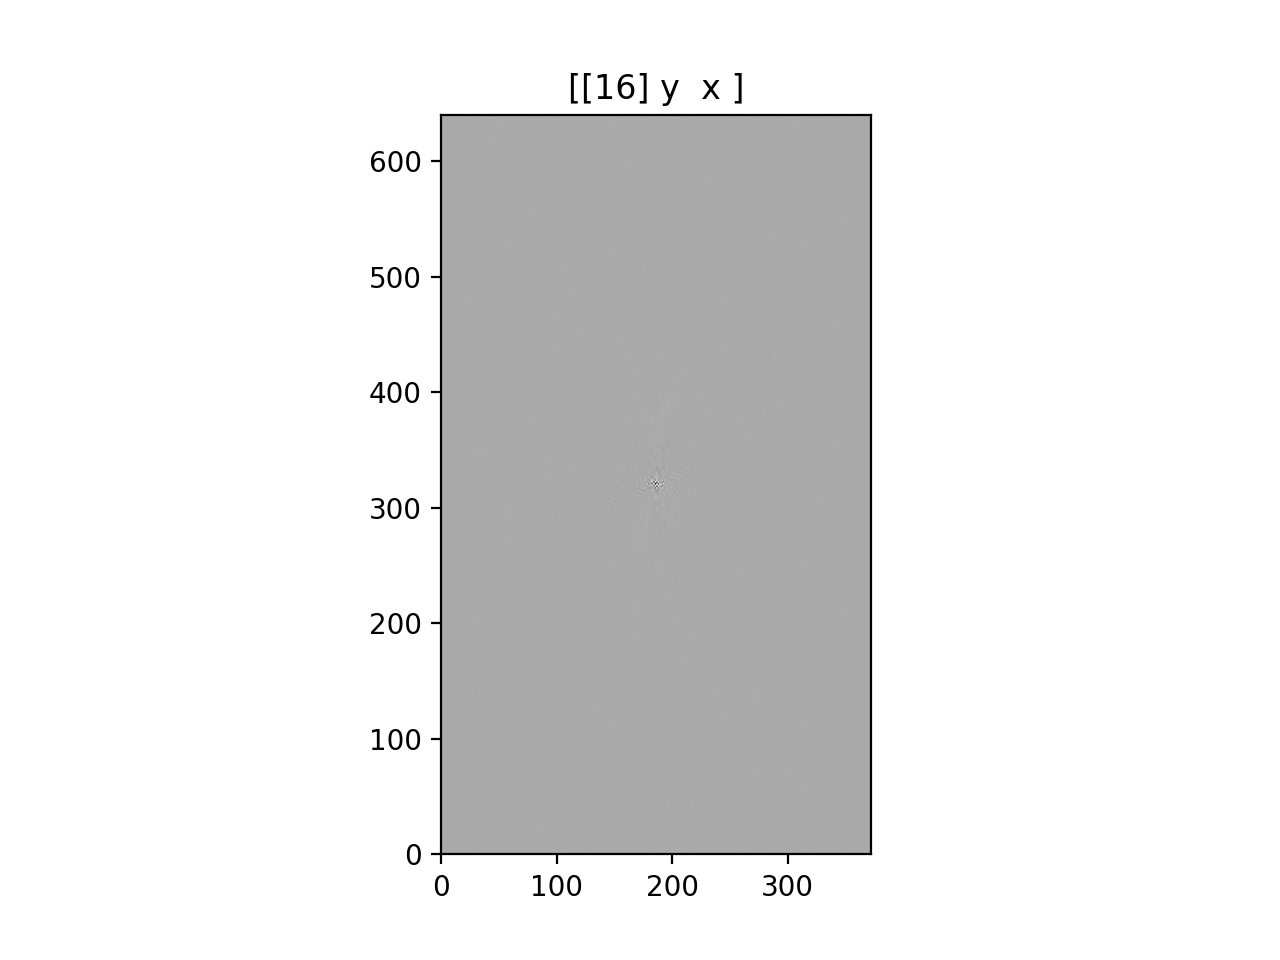

In [6]:
# [esc] + m (magnitude)
# [esc] + '[', ']' (contrast)
# [esc] + h (help)
# [esc] + arrows to change slices
# [esc] + g (grid mode)
# [esc] + l (log scale)
pl.ImagePlot(
    kspace,
    mode = "l"
            )

We can also plot the reconstructed MR image that they provide us with. This can't be seen in HTML, but the interactive tools allows one to scroll through the different slices.

<IPython.core.display.Javascript object>


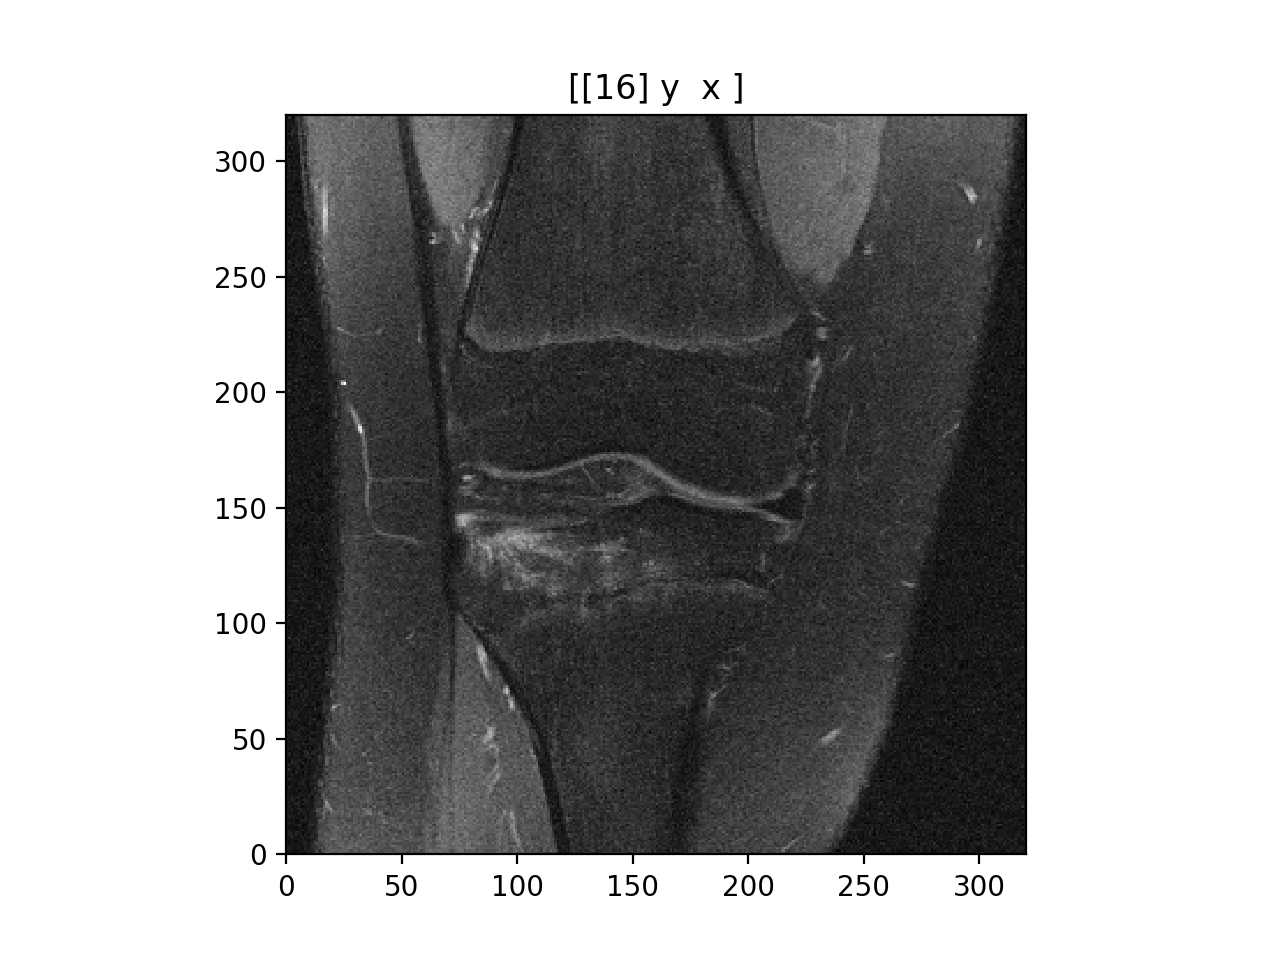

In [5]:
pl.ImagePlot(img)

### Reconstructing image ourselves, from k-space

Since we will be undersampling the k-space ourselves, it is necessary to be able to reconstruct MR images from k-space data as well. We can do this with an inverse fast Fourier transform (IFFT). We see that this image looks almost identical (with the exception of cropping, which we will do later too) to the reconstructed one they provided us with!

<IPython.core.display.Javascript object>


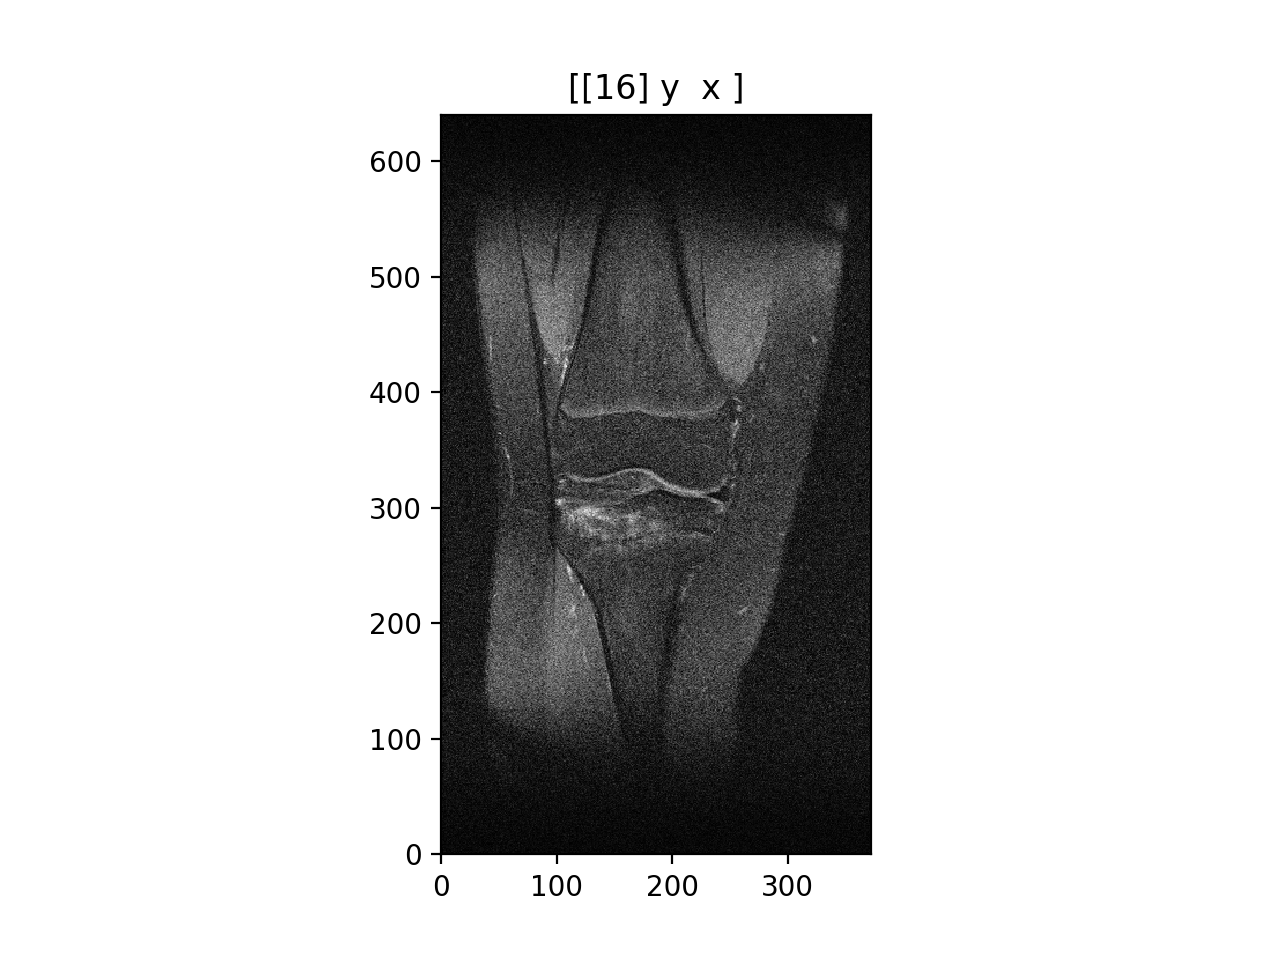

In [9]:
# IFFT 
# Usually, 2D-centered IFFT on the kspace can transform kspace to image domain
# This can be done with sp.ifft
im = sp.ifft(kspace, axes=AXES[DATASET])
pl.ImagePlot(im)

### Simulate undersampled k-space

Now, we can simulate an undersampled k-space by using a mask to choose select points from the fully sampled k-space. `center_fraction` represents how much of the center of the k-space we want to preserve, and the `accelerations` represents the speed-up of acquisition (i.e. the reciprocal of the proportion of the original number of samples we want)

In [10]:
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[4])
# This is a mask function that can generate random mask
# but it is for pytorch so let's generate mask and transfer to numpy compatible

mask = np.array(mask_func(kspace.shape))

kspace_us = kspace * mask # Now this is the undersampled kspace

We can reconstruct this image using IFFT and plot it. It looks similar to the image plotted above, except it is noticably more blurry and has worse contrast. This is due to the k-space undersampling.

<IPython.core.display.Javascript object>


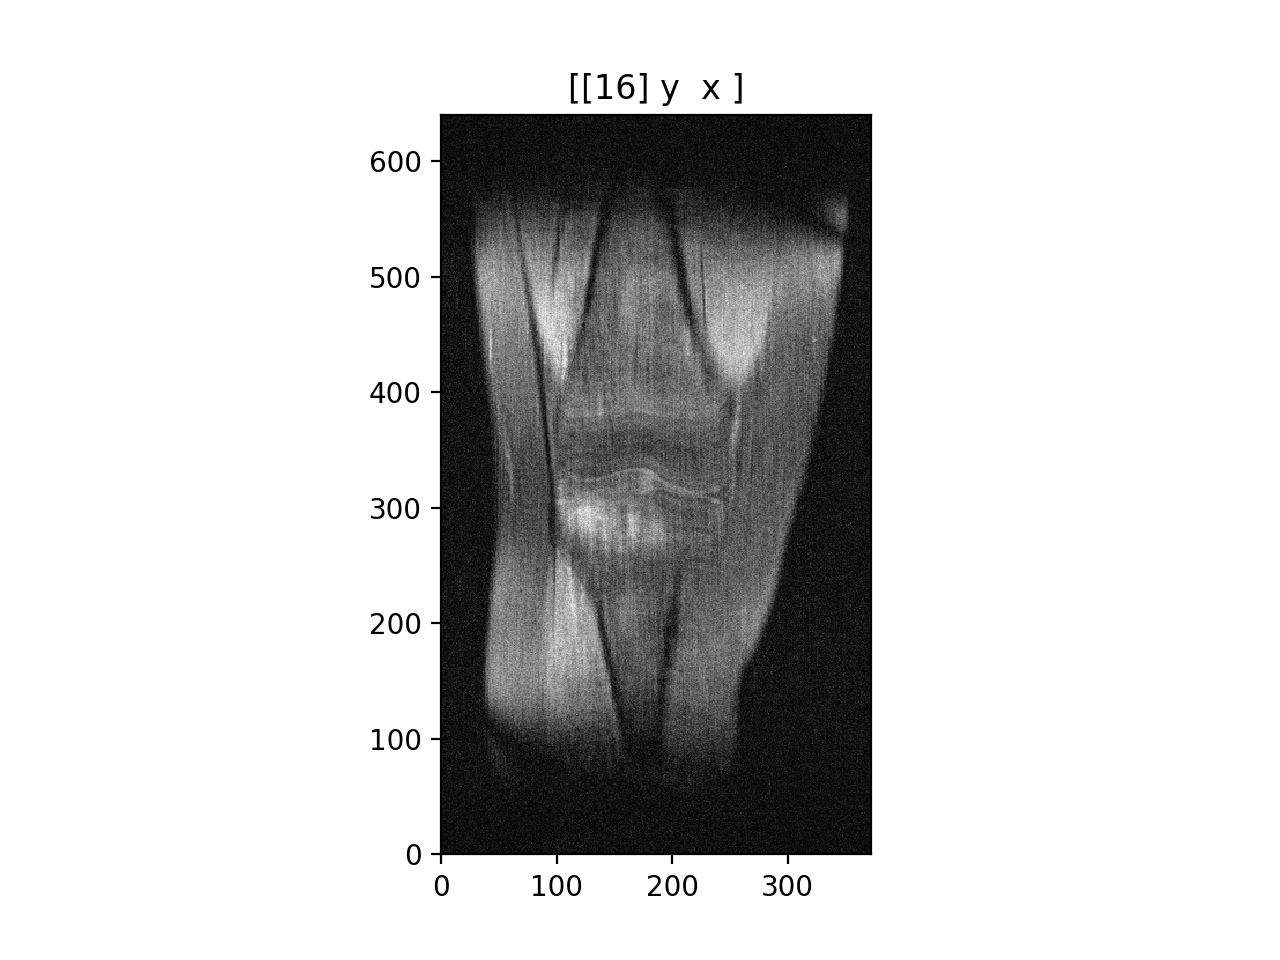

In [11]:
im_us = sp.ifft(kspace_us,axes=AXES[DATASET])
pl.ImagePlot(im_us)

### Portable code

Now, we write a bunch of helper functions to encapsulate the code we wrote above. Our ultimate goal is to create an ndarray of undersampled MR images for the input and a corresponding ndarray of fully sampled MR images for the output.

In [24]:
def _get_kspace_and_reconstruction_rss(filename):
    """
    @params filename: full path to .h5 mri file
    @return kspace data of that particular file
    """
    try:
        with h5py.File(filename, 'r') as hr:
            return hr['kspace'][:], hr['reconstruction_rss'][:]
    except:
        print(f'Error could not open {filename}')

def _get_kspace_undersampled(kspace, center_fractions = [0.04], accelerations = [4]):
    """
    @params kspace: from _get_kspace_and_reconstruction_rss(filename)
    @params center_fractions: for undersampling, 
        N*center_fraction columns in center corresponding to low-frequencies
    @params accelerations: how much mri acquisition is sped up
    @return undersampled k-space
    """
    mask_func = RandomMaskFunc(
        center_fractions = center_fractions, 
        accelerations = accelerations
    )
    mask = np.array(mask_func(kspace.shape))
    return kspace * mask

def _get_mri_im(
#     kspace, 
    reconstruction_rss,
    kspace_undersampled, 
    DATASET
):
    """
    # @params kspace: from _get_kspace_and_reconstruction_rss(filename)
    @params reconstruction_rss: reconstructed MR image of fully sampled kspace, provided
    @params kspace_undersampled: mask-undersampled k-space from _get_kspace_undersampled
    @params DATASET: i.e. 'singlecoil_challenge' or 'multicoil_challenge'
    @return (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    undersampled_im = sp.ifft(kspace_undersampled, axes=AXES[DATASET])
#     fullysampled_im = sp.ifft(kspace, axes=AXES[DATASET])
    
    #crop to make sure images are all the same size
    undersampled_crop = sp.resize(
        undersampled_im,
        [1, 30, 320, 320]
    )
    
    fullysampled_crop = sp.resize(
        reconstruction_rss,
        [1, 30, 320, 320]
    )
    
    
    return (
        undersampled_crop,
        fullysampled_crop,
    )
    

def get_datum_from_single_file(filename, DATASET):
    """
    user-facing function for tf Dataset object
    @params filename: full path to .h5 mri file
    @params DATASET: i.e. 'singlecoil_challenge' or 'multicoil_challenge'
    @return (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    kspace, reconstruction_rss = _get_kspace_and_reconstruction_rss(filename)
    kspace_undersampled = _get_kspace_undersampled(kspace)
    return _get_mri_im(
        reconstruction_rss,
        kspace_undersampled,
        DATASET,
    )


def get_data_from_files(filenames, DATASET):  
    """
    user-facing function for tf Dataset object
    @params filenames: list of full paths to .h5 mri files
    @params DATASET: i.e. 'singlecoil_train' or 'multicoil_train'
    @return ndarray of 
        (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    undersampled_images = np.ones((1, 30, 320, 320))
    fullysampled_images = np.ones((1, 30, 320, 320))
    for mri_path in filenames:
        try:
            undersampled_crop, fullysampled_crop = get_datum_from_single_file(
                mri_path, DATASET
            )
            undersampled_images = np.vstack(
                (undersampled_images, undersampled_crop)
            )
            fullysampled_images = np.vstack(
                (fullysampled_images, fullysampled_crop)
            )
        except:
            print(f'could not open file {mri_path}')
            send2trash(mri_path)
            print(f'sent file {mri_path} to trash')
            
    return undersampled_images[1:], fullysampled_images[1:]

#


We can now create out TensorFlow Dataset object, and we can shuffle it as well. Let's see what `ds.take(1)` looks like to the computer.

In [28]:
undersampled, fully_sampled = get_data_from_files(mri_paths, DATASET)
ds = tf.data.Dataset.from_tensor_slices((undersampled, fully_sampled))
ds = ds.shuffle(150,seed=123,reshuffle_each_iteration=True)
ds.take(1)

<TakeDataset shapes: ((30, 320, 320), (30, 320, 320)), types: (tf.complex128, tf.float64)>

<IPython.core.display.Javascript object>


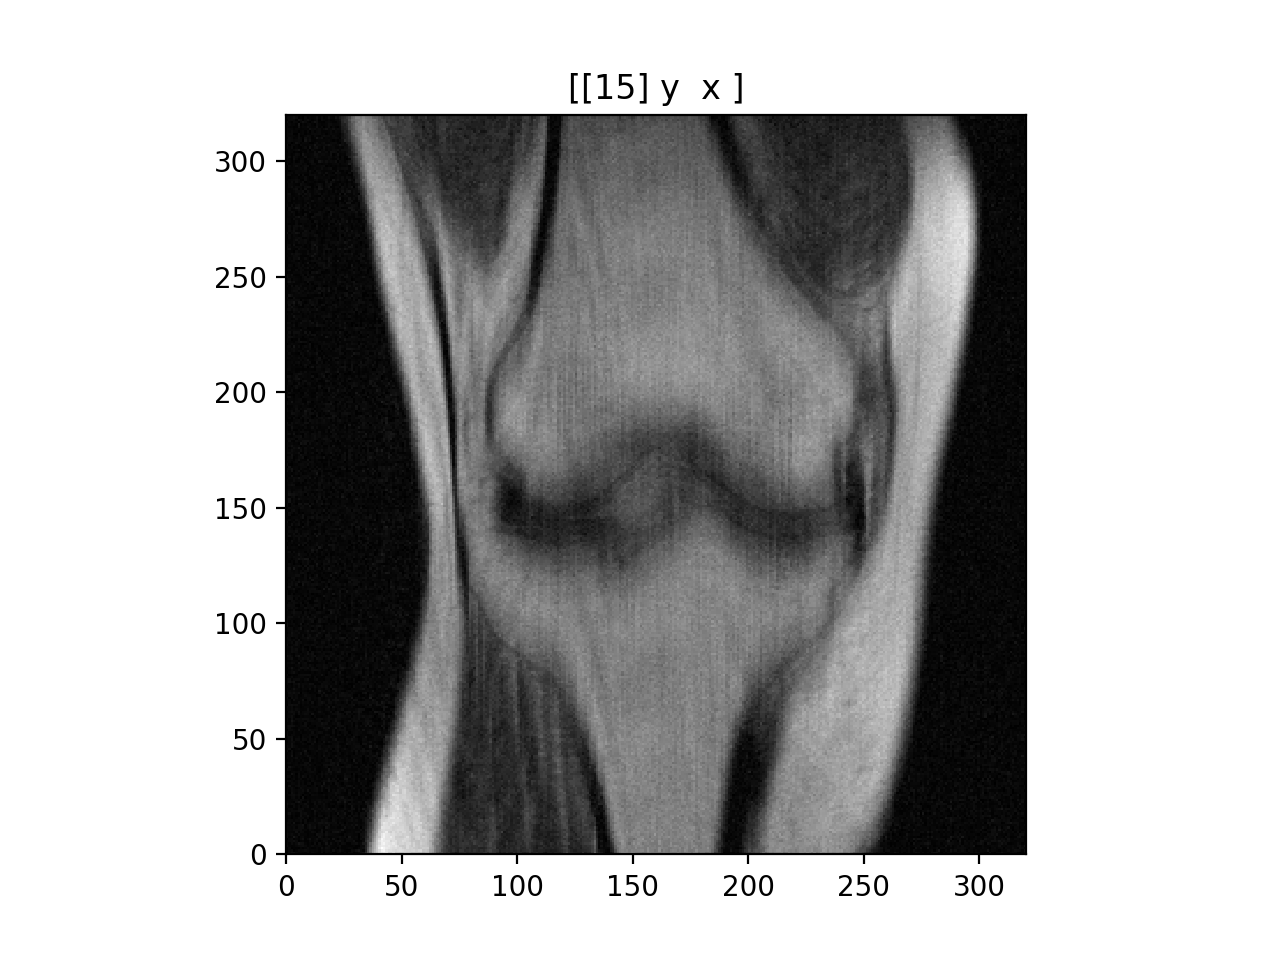

<IPython.core.display.Javascript object>


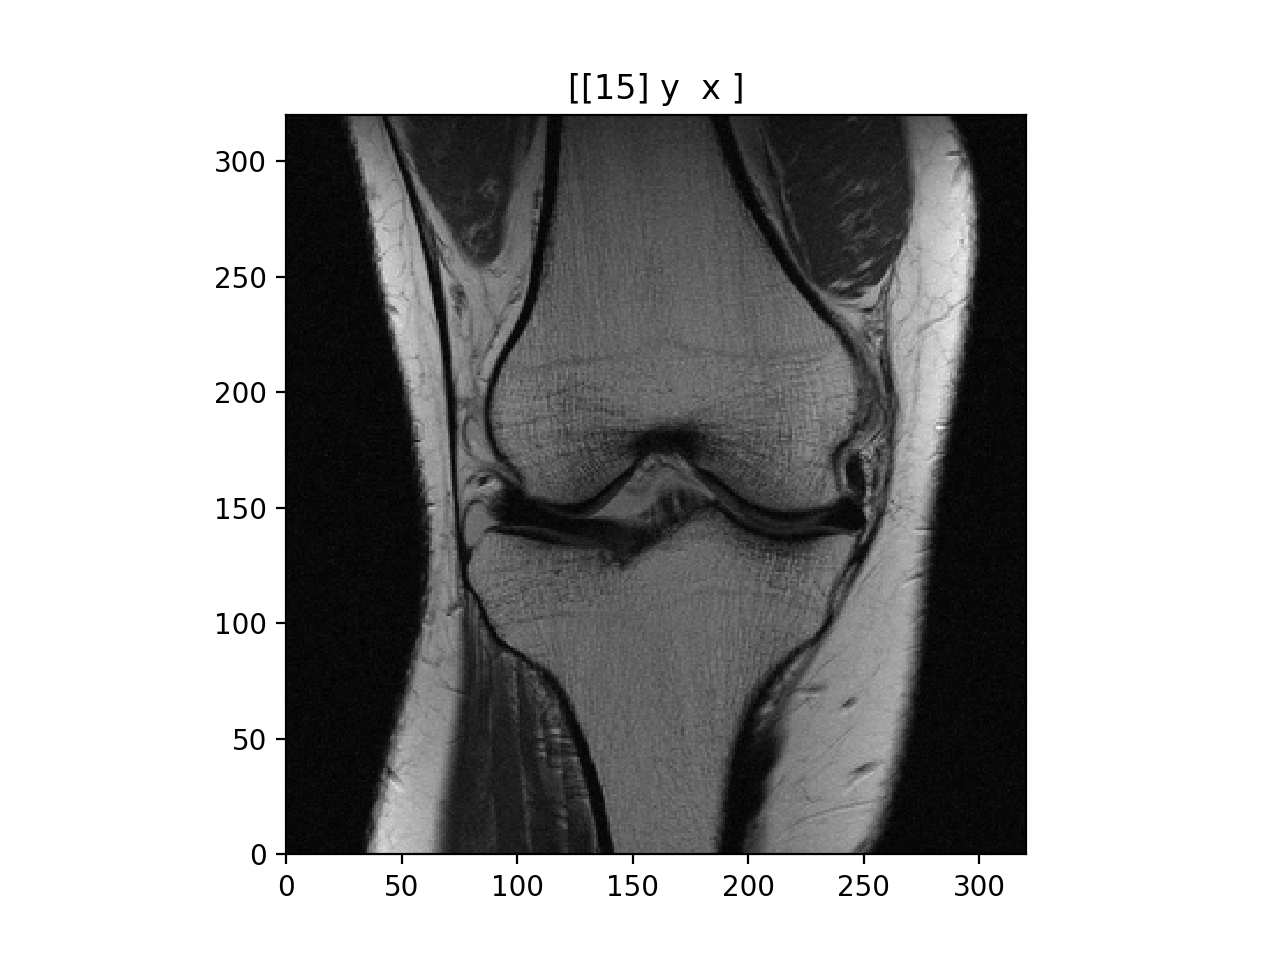

In [31]:
for undersampled_im, fullysampled_im in ds.take(1):
    pl.ImagePlot(undersampled_im)
    pl.ImagePlot(fullysampled_im)

This is a really nice comparison of what the partially sampled k-space (top) fully sampled k-space (bottom) will do to the reconstruction of the MR image. 


Normally for MRI, there is not much preprocessing beyond what has already been done. I could not find a golden standard with which to augment the dataset, but I may consult my SURF mentor in the coming days for more information. This is likely due to the fact that MRIs are already so rich with information, and improper augmentation may cause the GAN to hallucinate. In this particular project, we potentially have access to thousands of MRIs (the limitation is the disk quota, not the dataset itself), so I will go to OH this week to discuss how we may deal with this issue. While it may not be practical to store thousands of MRIs on the Caltech Clusters, I would imagine that it would be theoretically preferable to leverage the large dataset, rather than augment the current dataset.


Some more statistics: currently, we have $100$ MRIs in the dataset. I think it is interesting to note that there are other datasets availble from NYU fastMRI as well. Mainly, they also have multicoil knee, DICOM knee, multicoil brain, and DICOM brain datasets, each of which have hundreds of MR images as well. Based on how the disc space works out, it might be interesting to see if we can train the GAN to simulate super-resolution and deblurring for multiple types of MRIs.

### Bibliography
Will be in better format once we're off JupyterNotebook

Bustin, A., Fuin, N., Botnar, R. M., & Prieto, C. (2020). From Compressed-Sensing to Artificial Intelligence-Based Cardiac MRI Reconstruction. Frontiers in Cardiovascular Medicine, 7. https://doi.org/10.3389/fcvm.2020.00017


F. Knoll et al., "fastMRI: A publicly available raw K-space and DICOM dataset of knee images for accelerated MR image reconstruction using machine learning", Radiol.: Artif. Intell., vol. 2, no. 1, 2020.

Ye, J.C. Compressed sensing MRI: a review from signal processing perspective. BMC biomed eng 1, 8 (2019). https://doi.org/10.1186/s42490-019-0006-z

Zbontar J, Knoll F, Sriram A, et al. fastMRI: An Open Dataset and Bench-  marks for Accelerated MRI. arXiv [cs.CV]. http://arxiv.org/abs/1811.08839. Published 2018. 